# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, we will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Our goal is to understand what factors make a car more or less expensive.  As a result of our analysis, we should provide clear recommendations to our client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Our first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

The used car market is a dynamic and mutifaceted industry that presents various opportunities and challenges for buisnesses and consumers. The Global used car market is substatial and continues to grow. In 2021, it was valued at approximately $1.5 trillion and is expected to grow at the CAGR of around 6% from 2022 to 2028. The U.S is one of the largest markets of used cars, with millions of vehicles sold annually. Recently during pandemic, used car market saw huge demand, bumping used car prices significantly. The Goal of this analysis is to develop a predictive model that can help guide consumers and delears in deciding appropriate pricing for the used cars. 

### Objectives
1. Understand the relationship between various features and car prices.
2. Build and evaluate multiple regression models to predict used car prices. 
3. provide actionable insights based on model findings.

### Importing Libraries

In [165]:
# Importing modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express  as px
import plotly.graph_objects as go
import seaborn as sns

from sklearn.preprocessing import LabelEncoder


from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector as SFS
#from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score

import warnings
from sklearn import set_config
set_config(display='diagram')
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

DEBUG = True # setting debug flag 

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

### Data
The Used Car Datase from Kaggle contains total 17 variables/features, out of those 4 are numeric. Here is brief discription on 
1. **id**: Record ID number
2. **region**: Region name where transaction took place
3. **price**: Car Sale Price
4. **year**: Car Model Year
5. **manufacturer**: Car Manufacturer
6. **model**: Car Model
7. **condition**: Condition of the Car
8. **cylinders**: Number of Cylinders in the Car
9. **fuel**: Type of Fuel Used
10. **odometer**: Odometer Reading
11. **title_status**: Status of the Car Title
12. **transmission**: Type of Transmission
13. **VIN**: Vehicle Identification Number
14. **drive**: Type of Drive (e.g., FWD, RWD, AWD)
15. **size**: Size of the Car
16. **type**: Type of Car (e.g., sedan, SUV)
17. **paint_color**: Color of the Car's Paint
18. **state**: State where the Car is Located

The column **price** contains Price at which car was sold to, this will be our **Target** variable that we will try to Predict.

In [166]:
# Load dataset
df = pd.read_csv('data/vehicles.csv')
df.tail(3)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
426877,7301591147,wyoming,34990,2020.0,cadillac,xt4 sport suv 4d,good,NaN,diesel,4174.0,clean,other,1GYFZFR46LF088296,NaN,NaN,hatchback,white,wy
426878,7301591140,wyoming,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,clean,other,58ABK1GG4JU103853,fwd,NaN,sedan,silver,wy
426879,7301591129,wyoming,30590,2019.0,bmw,4 series 430i gran coupe,good,NaN,gas,22716.0,clean,other,WBA4J1C58KBM14708,rwd,NaN,coupe,NaN,wy


In [167]:
#display basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [168]:
#Display descriptive stastics for numeric columns
df.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


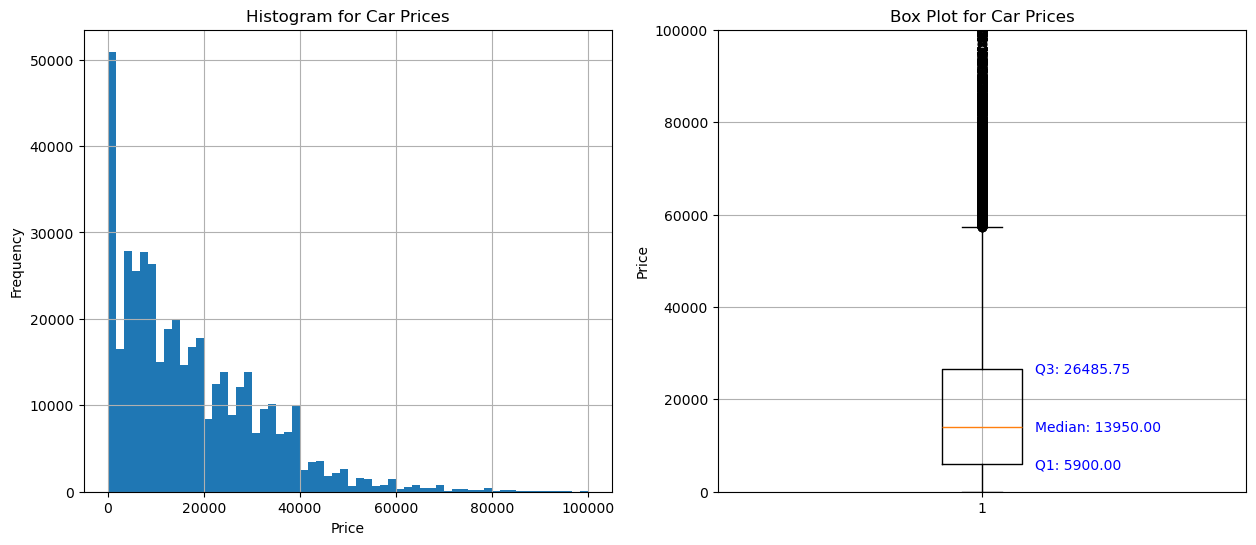

In [169]:

fig, ax = plt.subplots(1,2, figsize = (15,6))
# Histogram plot
ax[0].hist(df[(df['price'] >=0) & (df['price'] <= 100000)]['price'], bins=60)
ax[0].set_title('Histogram for Car Prices')
#ax[0].set_xlim([0, 1000000])  
ax[0].set_xlabel('Price')
ax[0].set_ylabel('Frequency')
ax[0].grid(True)

## KDE plot
#sns.kdeplot(df[(df['price'] >= 0) & (df['price'] <= 60000)]['price'], ax=ax[0], color='r')

# Boxplot
ax[1].boxplot(df['price'], vert=True)
ax[1].set_ylim(0, 100000)
ax[1].set_title('Box Plot for Car Prices')
ax[1].set_ylabel('Price')
ax[1].grid(True)

# Calculate quantiles
q1 = df['price'].quantile(0.25)
median = df['price'].quantile(0.5)
q3 = df['price'].quantile(0.75)

# Annotate quantiles on the box plot
ax[1].text(1.1, q1, f'Q1: {q1:.2f}', va='center', ha='left', color='blue')
ax[1].text(1.1, median, f'Median: {median:.2f}', va='center', ha='left', color='blue')
ax[1].text(1.1, q3, f'Q3: {q3:.2f}', va='center', ha='left', color='blue')

plt.savefig('images/Distribution_Target_Variable_Price.png', dpi=300, bbox_inches='tight')
plt.show()



**Price Distribution**

Based on the describe functional results and above box plot, filtering rows with price less than 1000. (Many rows have price 0)


In [170]:
#filtering price data from 1000 to 60000
df = df[(df['price'] >=1000) & (df['price'] <= 60000)]
print (f'new df shape {df.shape}')
df. describe()
#initial price was chosen to be 1 to 500000 but above 60K data points are less and they are the outlier so above 60K should be ignored

new df shape (374299, 18)


,id,price,year,odometer
count,3.742990e+05,374299.000000,373289.000000,3.722810e+05
mean,7.311457e+09,18571.453536,2010.918347,9.918325e+04
std,4.476974e+06,12852.021397,9.524592,1.858533e+05
min,7.207408e+09,1000.000000,1900.000000,0.000000e+00
25%,7.308073e+09,7900.000000,2008.000000,3.960800e+04
50%,7.312556e+09,15800.000000,2013.000000,8.901500e+04
75%,7.315237e+09,27495.000000,2017.000000,1.370000e+05
max,7.317101e+09,60000.000000,2022.000000,1.000000e+07


In [171]:
# finding  all 'NAN' values
df.isnull().sum()

id                   0
region               0
price                0
year              1010
manufacturer     14527
model             4211
condition       139407
cylinders       152342
fuel              2562
odometer          2018
title_status      6377
transmission      1773
VIN             144645
drive           113877
size            268032
type             79946
paint_color     106947
state                0
dtype: int64

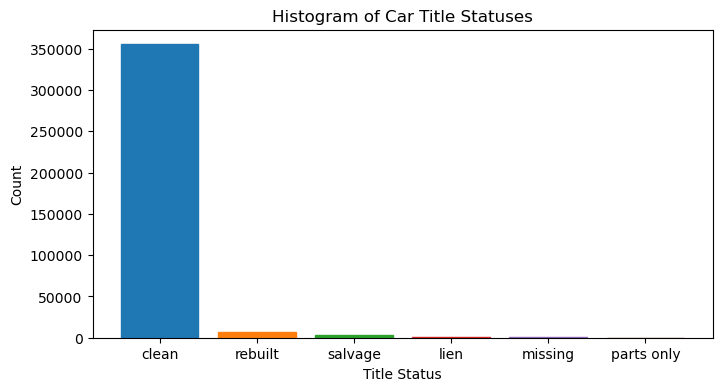

In [172]:
#Visulization for 'title_status'

title_status_counts = df['title_status'].value_counts()

# Create the histogram
plt.figure(figsize=(6, 3))
bars = plt.bar(title_status_counts.index, title_status_counts.values, color=plt.cm.tab10.colors)

# Add color to bars
for bar, color in zip(bars, plt.cm.tab10.colors):
    bar.set_color(color)

# Add labels and title
plt.xlabel('Title Status')
plt.ylabel('Count')
plt.title('Histogram of Car Title Statuses', loc='center')

# Customize the layout
plt.gcf().set_size_inches(8, 4)

# Show the plot
plt.show()

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

#### Fill up missing entries for 'manufacturer'
***Strategy***
- create mapping for model and manufacturer (assumption : no two manufacturers will have same model name and thus mapping can be used.)
- where manufacturer is mssing, use entry from the map 

In [173]:
# Create a Series that maps models to manufacturers (where manufacturer is not null)

model_to_manufacturer = df[df.manufacturer.notnull()].drop_duplicates(subset='model').set_index('model')['manufacturer']
#print(model_to_manufacturer)

# Fill missing manufacturers based on the model_to_manufacturer mapping
df.loc[df.manufacturer.isnull(), 'manufacturer'] = df['model'].map(model_to_manufacturer)
if DEBUG:
    null_count = df.isnull().sum()
    print(null_count[null_count > 0])

year              1010
manufacturer     13807
model             4211
condition       139407
cylinders       152342
fuel              2562
odometer          2018
title_status      6377
transmission      1773
VIN             144645
drive           113877
size            268032
type             79946
paint_color     106947
dtype: int64


***Dropping null rows for `'year'`, `'model'` and `'manufacturer'` as null rows are comparatively low***



In [174]:
df = df.dropna(subset=['year', 'manufacturer', 'model'])
if DEBUG:
    null_count = df.isnull().sum()
    print(null_count[null_count > 0])

condition       132678
cylinders       144378
fuel              2146
odometer          1905
title_status      5938
transmission      1643
VIN             134321
drive           106958
size            255653
type             73588
paint_color     100913
dtype: int64


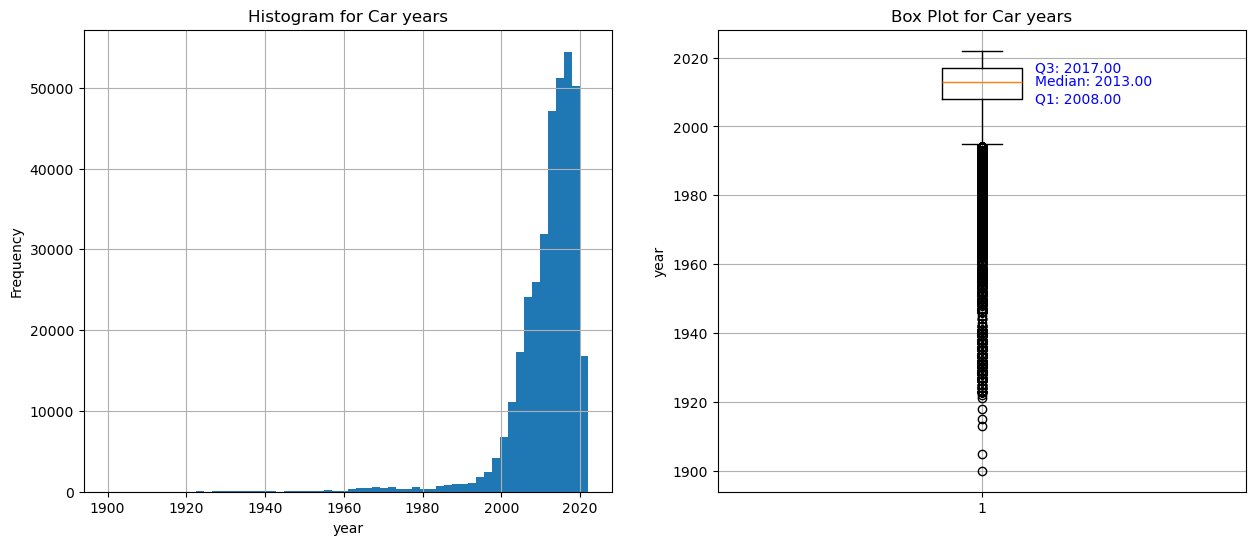

In [175]:
fig, ax = plt.subplots(1,2, figsize = (15,6))
# Histogram plot
ax[0].hist(df['year'], bins=60)
ax[0].set_title('Histogram for Car years')
#ax[0].set_xlim([0, 1000000])  
ax[0].set_xlabel('year')
ax[0].set_ylabel('Frequency')
ax[0].grid(True)

## KDE plot
#sns.kdeplot(df['year'], ax=ax[0], color='r')

# Boxplot
ax[1].boxplot(df['year'], vert=True)
#ax[1].set_ylim(0, 100000)
ax[1].set_title('Box Plot for Car years')
ax[1].set_ylabel('year')
ax[1].grid(True)

# Calculate quantiles
q1 = df['year'].quantile(0.25)
median = df['year'].quantile(0.5)
q3 = df['year'].quantile(0.75)

# Annotate quantiles on the box plot
ax[1].text(1.1, q1, f'Q1: {q1:.2f}', va='center', ha='left', color='blue')
ax[1].text(1.1, median, f'Median: {median:.2f}', va='center', ha='left', color='blue')
ax[1].text(1.1, q3, f'Q3: {q3:.2f}', va='center', ha='left', color='blue')

plt.savefig('images/Distribution_Target_Variable_year.png', dpi=300, bbox_inches='tight')
plt.show()



In [176]:
#Based on above distribution, limiting yearly data to 1980 and hight
df = df[df['year'] >=1980]
#df['year'].head()

#### Addressing 'cylinders' feature
- overall null rows are significantly larger , 144K
- values for this feature are in formate 'number cylinders' i.e. 6 cyclinders, except 'others'
    - parsing number out get number of cylinders, 'others' will turn to NAN in this process
- If car is electric --> Assign cylinders = 0
- First, get median value of cylinders grouped by 'model' and use that to fill
- stil there are some NAN, get overall median and use it to fill


In [177]:
print(f' original cyclinder values : {df.cylinders.unique()}')
# Extract numeric part from the 'cylinders' column
df['cylinders'] = df['cylinders'].str.extract('(\d+)').astype(float) # other turned to 'NAN' which will be handled as original NAN
df.loc[df['fuel'] == 'electric', 'cylinders'] = 0



median_cylinders =  df.groupby('model')['cylinders'].median() # get meidan value of cycliders grouped by model
overall_median = df['cylinders'].median()  # Calculate overall median for any missing model medians

df['cylinders'] = df.apply(
    lambda row: median_cylinders[row['model']] if pd.isnull(row['cylinders']) else row['cylinders'],
    axis=1
)
df['cylinders'] = df.apply(
   lambda row: overall_median if pd.isnull(row['cylinders']) else row['cylinders'],
    axis=1
)
print(f' new cyclinder values : {df.cylinders.unique()}')
if DEBUG:
    null_count = df.isnull().sum()
    print(null_count[null_count > 0])

 original cyclinder values : ['8 cylinders' '6 cylinders' nan '4 cylinders' '5 cylinders'
 '10 cylinders' '3 cylinders' 'other' '12 cylinders']
 new cyclinder values : [ 8.   6.   4.   0.   5.   4.5 10.   3.   7.  12.   5.5  2.   6.5]
condition       131095
fuel              2137
odometer          1891
title_status      5934
transmission      1641
VIN             129668
drive           104935
size            252591
type             71311
paint_color      98881
dtype: int64


#### Dropping features 
dropping columns `'VIN'` and `'size'` as those features are not important to predict price, Size should be covered by model, also both have significant number of missing data
- dropping `'region'` as `'state'` should be able to cover it and thus it will be closely correlated to 'state'
- dropping `'fuel'` after first analysis where `'fuel_diesel'` was having high `coef` which is seconday effect of diesel being used in higher price trucks so removing it as well. 


In [178]:

df = df.drop(columns=['id', 'VIN','size', 'region', 'paint_color', 'fuel'])
if DEBUG:
    null_count = df.isnull().sum()
    print(null_count[null_count > 0])


condition       131095
odometer          1891
title_status      5934
transmission      1641
drive           104935
type             71311
dtype: int64


#### Fillig up 'odometer' null entries
- get median 'odometer' values grouped by year
- fill up 'NAN' row if that year median entry is available
    - if that year entry is not available, use the closest available entry to fill. 

In [179]:

# for odometer assumption, use median value by year and use that to estimate missing values.
yearly_odometer = df.groupby(['year'])['odometer'].median()

def fill_odometer(row):
    if pd.isnull(row['odometer']):
     # Get the odometer value for the year of the current row

        year_odometer = yearly_odometer.get(row['year'])

        if pd.isnull(year_odometer):
            # Find the closest year with available data

            closet_year = yearly_odometer.dropna().sub(row['year']).abs().idxmin()
            return yearly_odometer[closet_year]
        else:
            return year_odometer
    else:
        return row['odometer']
df['odometer'] = df.apply(fill_odometer, axis=1)
#plt.plot(df['year'], df['odometer'])
if DEBUG:
    null_count = df.isnull().sum()
    print(null_count[null_count > 0])

condition       131095
title_status      5934
transmission      1641
drive           104935
type             71311
dtype: int64


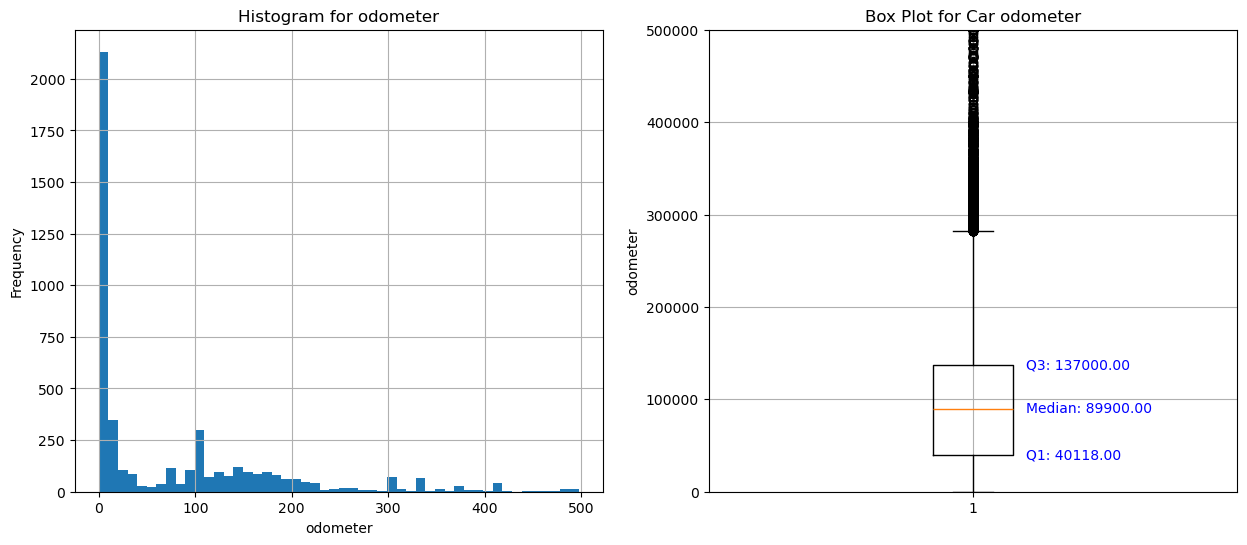

In [180]:
fig, ax = plt.subplots(1,2, figsize = (15,6))
# Histogram plot
ax[0].hist(df['odometer'][df['odometer']<500], bins=50)
ax[0].set_title('Histogram for odometer')
#ax[0].set_xlim([0, 600000])  
ax[0].set_xlabel('odometer')
ax[0].set_ylabel('Frequency')
ax[0].grid(True)

## KDE plot
#sns.kdeplot(df['odometer'], ax=ax[0], color='r')

# Boxplot
ax[1].boxplot(df['odometer'], vert=True)
ax[1].set_ylim(0, 500000)
ax[1].set_title('Box Plot for Car odometer')
ax[1].set_ylabel('odometer')
ax[1].grid(True)

# Calculate quantiles
q1 = df['odometer'].quantile(0.25)
median = df['odometer'].quantile(0.5)
q3 = df['odometer'].quantile(0.75)

# Annotate quantiles on the box plot
ax[1].text(1.1, q1, f'Q1: {q1:.2f}', va='center', ha='left', color='blue')
ax[1].text(1.1, median, f'Median: {median:.2f}', va='center', ha='left', color='blue')
ax[1].text(1.1, q3, f'Q3: {q3:.2f}', va='center', ha='left', color='blue')

plt.savefig('images/Distribution_Target_Variable_odometer.png', dpi=300, bbox_inches='tight')
plt.show()



In [181]:
df.shape

(350788, 12)

In [182]:
df=df[(df['odometer'] > 0) & (df['odometer'] <= 500000)]
df.shape

(349704, 12)

In [183]:
#based on above data, limiting odometer t0 500000 miles

#### Filling remaining features with 'NAN' as `'Not Specified'`
- features and number of rows to fill


| Feature       | # of Null rows |
|---------------|----------------|
| condition     | 132678         |
| title_status  | 5938           |
| transmission  | 1643           |
| drive         | 106958         |
| type          | 73588          |

In [184]:
#filling all other Null as "Not Specified"

df = df.fillna('Not Specified')
if DEBUG:
    #print(df.condition.value_counts(dropna=False, ascending=False, normalize=True))
    print(df.isnull().sum())

price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
odometer        0
title_status    0
transmission    0
drive           0
type            0
state           0
dtype: int64


***creating `'car_age'` feature to use instead of 'year'***

In [185]:
import datetime

# Get the current year
current_year = datetime.datetime.now().year
# Calculate the age of the car
df['car_age'] = current_year - df['year']

df.drop(columns='year', inplace=True) # dropping year feature as 'car_age' will be used


In [186]:
# https://online.stat.psu.edu/stat462/node/180/
# VIF - measure of the multicollinearity in the independent features

def vif(exogs, data): # exogs are column names.and data is full data frame. 
    vif_dict={}

    for exog in exogs:
        not_exogs = [i for i in exogs if i != exog] # List of columns which is not selected for analysis.
        X, y = data[not_exogs], data[exog] # X stores data frame for other columns, y  stores targeted column. each column is targeted one by one. 

        r_squared = LinearRegression().fit(X,y).score(X,y)

        #calc the VIF
        vif = 1/(1-r_squared)
        vif_dict[exog] = vif
    return pd.DataFrame({"VIF" : vif_dict})

In [187]:
df_pre_numeric_cols = df.select_dtypes(include=['number']).columns.to_list()
df_pre_numeric = df[df_pre_numeric_cols].copy()
vif(df_pre_numeric.columns, df_pre_numeric).sort_values(by = 'VIF', ascending=False)

,VIF
price,2.439401
car_age,2.029424
odometer,1.846441
cylinders,1.431047


*** No highly correlated numeric features found ***

*** Simplifying car 'model' feature ***
- `objective` : reduce number of features when encoding is done on this categorical feature.
- first, parse the 'model' and extract very first element from value, some of the values are very long descriptions.
- rename 'f-' with 'f', as in many occurances it has f-150 while in other ocurrances its f150, so allginign them. 
- if number of entries for that 'model' is leass than 100, rename the 'model' with 'manufacturer' value to significantly reduce the # of columns. 

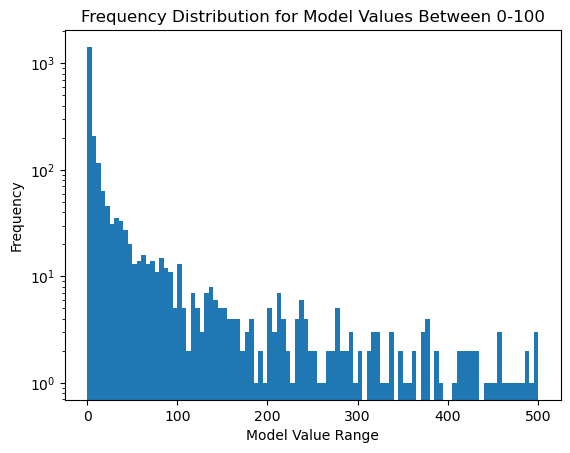

In [188]:

# Get unique values of the 'model' column
model_unique = df['model'].unique()
# Convert to DataFrame to save as CSV
model_unique_df = pd.DataFrame(model_unique, columns=['model'])
# Write to CSV file
model_unique_df.to_csv('model_unique.csv', index=False)
df['simplified_model'] = df['model'].apply(lambda x: ' '.join(x.split()[:1]))
# Replace 'f-' with 'f' in 'simplified_model'
df['simplified_model'] = df['simplified_model'].str.replace('f-', 'f', regex=False)
model_counts = df['simplified_model'].value_counts(ascending=True)
#print(model_counts)
plt.hist(model_counts,bins=100, range=(0,500), log=True)
plt.xlabel('Model Value Range')
plt.ylabel('Frequency')
plt.title('Frequency Distribution for Model Values Between 0-100')
plt.show()

less_common_models = model_counts[model_counts < 100].index
#print ( less_common_models)
df['simplified_model'] = np.where(df['simplified_model'].isin(less_common_models), df['manufacturer'], df['simplified_model'])
#df['simplified_model'] = np.where(df['simplified_model'].isin(less_common_models), 'others', df['simplified_model'])
#print(df[df['simplified_model'] == 'mirage'])




*** drop features `'model'` and `'manufacturer'` ***
- 'simplified_model' feature is creatd with 'model' column simplified so 'model' is not needed anymore.
-  'simplified_model' and 'manufacturer' should be somewhat correlated and 'model' would be a better feature to provide granularity. i.e tesla model-S will be signifiantly costly compared to model-3 even though both of them are 'sedan' and matching on all other features and manufacturer. 

In [189]:
df = df.drop(columns=['model', 'manufacturer']) #simplified model is created to replace this
numeric_columns = df.select_dtypes(include=['number']).columns.to_list()
columns_to_encode = df.select_dtypes(include='object').columns.to_list()
for column in columns_to_encode:
    print(f'{column} : {len(list(df[column].unique()))}')


condition : 7
title_status : 7
transmission : 4
drive : 4
type : 14
state : 51
simplified_model : 402


#### Heat-map on numerical features
- shows that 'car-age' and 'odometer' values increases, price decreases. In other words they have negative correlation, which makes sense.
- no. of cyclinders are positvely created to price as they provide more power and those cars are costly. 

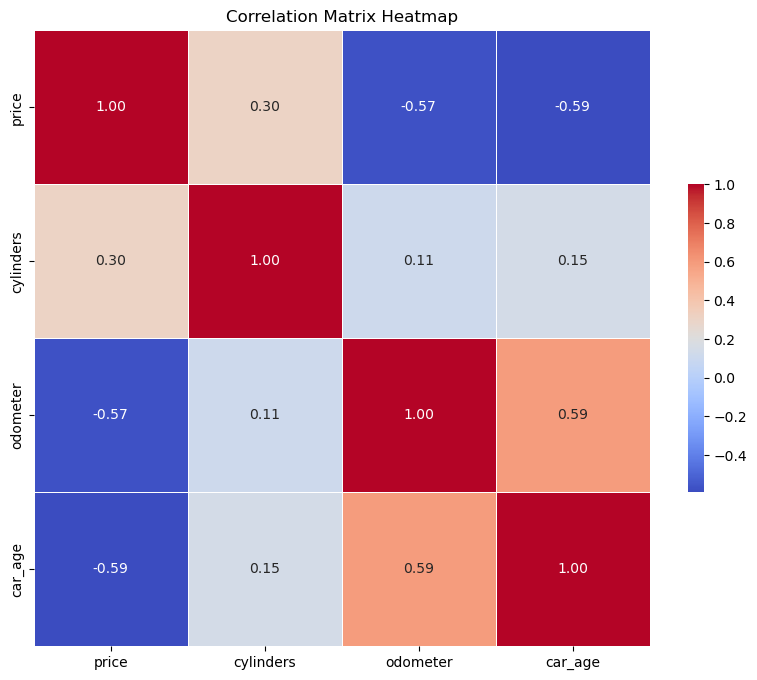

In [190]:
correlation_matrix = df[numeric_columns].corr()

plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Matrix Heatmap')
plt.show()

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [191]:
# creating train and test data-sets
X = df.drop('price', axis=1)
y = df['price']
print (X.isnull().sum()) # checking if there are any null values, there arent. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()

condition           0
cylinders           0
odometer            0
title_status        0
transmission        0
drive               0
type                0
state               0
car_age             0
simplified_model    0
dtype: int64


,condition,cylinders,odometer,title_status,transmission,drive,type,state,car_age,simplified_model
130233,Not Specified,4.0,21100.0,clean,automatic,Not Specified,Not Specified,hi,10.0,3
338687,Not Specified,6.0,21091.0,clean,Not Specified,Not Specified,convertible,pa,4.0,mustang
18276,Not Specified,6.0,197159.0,clean,automatic,Not Specified,SUV,ar,13.0,santa
292902,excellent,6.0,64582.0,clean,automatic,fwd,sedan,oh,10.0,avenger
140577,excellent,4.0,184420.0,clean,automatic,fwd,mini-van,il,18.0,mazda


### Machine Learning using Regression

In [192]:
numeric_columns_X = X.select_dtypes(include=['number']).columns.to_list()
columns_to_poly = ['car_age', 'odometer']  # selecing these featuers for polynomials. 
# create polynomial pipeline with scalling of polynomial features. 
poly_and_scale = Pipeline([
    ('polynomial', PolynomialFeatures(degree=2, include_bias=False)),  # using degree =2 
    ('scale', StandardScaler())  
])
# Create transformers - calls, poly and scale, onehotencoder and standard scaler. 
# onehotencoder is used to encode all categorical features. 

preprocessor = make_column_transformer ((poly_and_scale, columns_to_poly),
                                        (OneHotEncoder(drop='if_binary', sparse_output=False), columns_to_encode),
                                        (StandardScaler(), ['cylinders']), 
                                        remainder='passthrough', verbose_feature_names_out=False) # avoid to prepend the preprocessor name.



In [193]:
# initializing models ( using Linear regression and Ridge, Lasso is skipped as it takes long time to run with these many features.)
# considered Sequential Feature Selection but it was taking long computational time. 
models = {
    'Linear Regression' : Pipeline([('prepo', preprocessor),
                                    ('Linreg', LinearRegression())]),
    'Ridge' : Pipeline([('prepo', preprocessor),
                                    ('ridge', Ridge())]),
    'Lasso' : Pipeline([('prepo', preprocessor),
                                   ('lasso', Lasso(max_iter=10000))])
}

In [194]:
# Train and Evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  
    r2 = r2_score(y_test, y_pred)
    results[name]= {'RMSE' : rmse, 'R2' : r2}
    print (f'{name} : RMSE = {rmse:0.4f}, R2 = {r2:.4f}')
    

Linear Regression : RMSE = 5455.2928, R2 = 0.8165
Ridge : RMSE = 5454.4589, R2 = 0.8166
Lasso : RMSE = 5495.7834, R2 = 0.8138


#### Results
- Linear and Ridge both are having very similar RMSE and R2. 

### Cross Validation and Hyperparameter Tuning

In [195]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV, cross_val_score
import numpy as np

# Columns for polynomial features
columns_to_poly = ['car_age', 'odometer']

# Create polynomial and scaling pipeline
poly_and_scale = Pipeline([
    ('polynomial', PolynomialFeatures(include_bias=False)),  # Degree will be set in GridSearchCV
    ('scale', StandardScaler())
])

# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('poly_and_scale', poly_and_scale, columns_to_poly),
        ('onehot', OneHotEncoder(drop='if_binary', sparse_output=False), columns_to_encode),
        ('scaler', StandardScaler(), ['cylinders'])
    ],
    remainder='passthrough', 
    verbose_feature_names_out=False  # Avoid to prepend the preprocessor name
)

# Define the parameter grid for Ridge and Lasso, including polynomial degree
param_grid = {
    'Linear Regression': {
        'preprocessor__poly_and_scale__polynomial__degree': [1, 2, 3],  # The named transformer in the preprocessor
    },
    'Ridge': {
        'preprocessor__poly_and_scale__polynomial__degree': [1, 2, 3],  # The named transformer in the preprocessor
        'ridge__alpha': [0.1, 1.0,2, 10]
    },
    'Lasso': {
        'preprocessor__poly_and_scale__polynomial__degree': [1, 2, 3],  # The named transformer in the preprocessor
        'lasso__alpha': [0.01, 0.1, 1.0]
    }
}

# Initialize the models
models = {
    'Linear Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('Linreg', LinearRegression())
    ]),
    'Ridge': Pipeline([
        ('preprocessor', preprocessor),
        ('ridge', Ridge(max_iter=10000))
    ]),
    #'Lasso': Pipeline([
    #    ('preprocessor', preprocessor),
    #    ('lasso', Lasso(max_iter=10000))
    #])
}

# Performing cross-validation and hyperparameter tuning
best_models = {}
for name, model in models.items():
    if name in param_grid:
        grid = GridSearchCV(model, param_grid[name], cv=5, scoring='neg_mean_squared_error')
        grid.fit(X_train, y_train)
        best_models[name] = grid.best_estimator_
        best_rmse = np.sqrt(-grid.best_score_)
        print(f'Best {name}: {grid.best_params_}, RMSE= {best_rmse:.4f}')
    else:
        # For linear regression, perform cross-validation
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
        rmse_scores = np.sqrt(-scores)  # Convert negative MSE to RMSE
        best_models[name] = model
        print(f"{name}: Cross-validation RMSE = {rmse_scores.mean():.4f}")

Best Linear Regression: {'preprocessor__poly_and_scale__polynomial__degree': 3}, RMSE= 5459.3162
Best Ridge: {'preprocessor__poly_and_scale__polynomial__degree': 3, 'ridge__alpha': 2}, RMSE= 5458.7189


In [196]:
# Get the best Ridge model
best_ridge = best_models['Ridge']

# Get the new column names after preprocessing
preprocessor_fitted = best_ridge.named_steps['preprocessor']
new_column_names = preprocessor_fitted.get_feature_names_out()

# Print the new column names
#print("New Column Names:", new_column_names)

#### Training Results
- with Ridge alpha selection of 1.8 through `GridsearchCV` cross validation, Ridge RMSE is slightly beter than Linear Regression.
- selecting `'Ridge'` model as best model moving forward for further analysis and deployment. 

In [197]:
print( 'Evaluate best models on test data')
results = {}
for name, model in best_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score( y_test, y_pred)
    results[name] = {'RMSE' : rmse, 'R2' : r2}
    print(f'{name} : RMSE = {rmse:.4f}, R2 = {r2:.4f}')
    


Evaluate best models on test data
Linear Regression : RMSE = 5448.2068, R2 = 0.8170
Ridge : RMSE = 5447.9089, R2 = 0.8170


#### Test results
- on test data, Ridge performs better than Linear regression so moving ahead with Ridge.


In [198]:
# creating actual vs predicted dataframe for Ridge. 
best_ridge_model = best_models['Ridge']
y_pred = best_ridge_model.predict(X_test)

# create dataframe to show actual vs predicted
actual_vs_predicted_ridge_df = pd.DataFrame({'Actual': y_test, 'Predicted' : y_pred})
actual_vs_predicted_ridge_df.head()

,Actual,Predicted
416929,12950,14039.452789
72270,10999,12274.050455
111562,14999,23770.683553
148095,5995,2720.828757
121325,10500,18674.354737


In [199]:
ridge_model = best_ridge_model.named_steps['ridge']
coefficients = pd.Series(ridge_model.coef_, index=new_column_names)
intercept = ridge_model.intercept_

# Output the coefficients and intercept
sorted_coefficients = coefficients.sort_values(ascending=False)
#print("Coefficients:\n", sorted_coefficients)
print("Intercept:", intercept)

Intercept: 15422.753518135194


#### Definations
- ***Coefficient Value : *** The value of each coefficient represents the expected change in the target variable for a one-unit change in the corresponding feature, assuming all other features remain constant.
- ***Intercept: *** The intercept represents the expected value of the target variable when all features are zero.

In [200]:
# Write to CSV file
sorted_coefficients.to_csv('data/ridge_coefficients.csv', header=True, index=True)

# Notify that the file has been written
print("Coefficients have been written to 'ridge_coefficients.csv'")

Coefficients have been written to 'ridge_coefficients.csv'


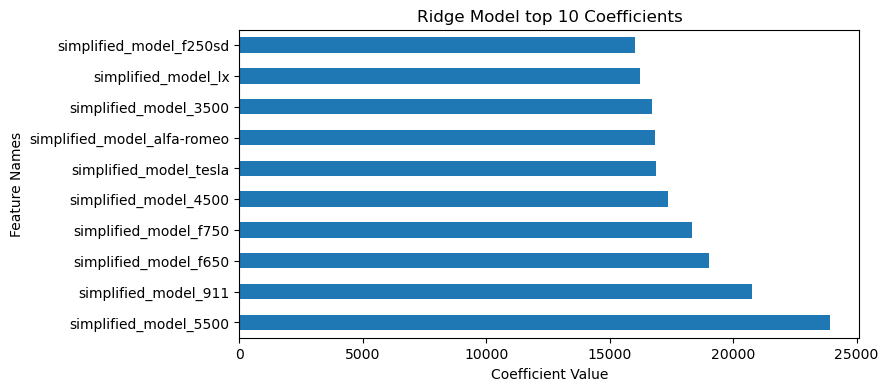

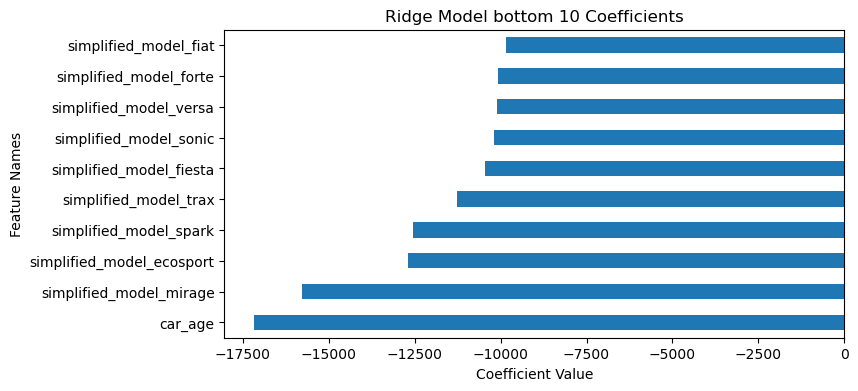

In [201]:

## Plotting top and bottom 10 coefficients in a horizontal bar plot
asc_dsc = [False, True]
for asc_type in asc_dsc:
    plt.figure(figsize=(8, 4))
    coefficients.sort_values(ascending=asc_type)[:10].plot(kind='barh')
    if asc_type == False :
        plt.title('Ridge Model top 10 Coefficients')
    else :
        plt.title('Ridge Model bottom 10 Coefficients')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature Names')
    plt.show()

### Important observations about Coefficients and Findings
- All coefficents sorted in descending order are located at [Download ridge_coefficients.csv](data/ridge_coefficients.csv)
1. **Prominent Positive Influencers:**
   - **High-Value Models:** Top models like `simplified_model_5500`, `simplified_model_911`, and `simplified_model_c10` show the highest positive coefficients, significantly boosting the model’s predicted value, likely indicating premium or highly sought-after vehicle models.

2. **Negative and Positive Dynamics in Age and Odometer:**
   - **Negative Coefficients for car_age and odometer:** Both `car_age` (-17180.42) and `odometer` (-3992.08) have negative coefficients, suggesting that as vehicles age or accumulate mileage, their value or some other positive attribute (like desirability or reliability) typically decreases.
   - **Positive Coefficients for Polynomial Terms (`car_age^2` and `odometer^3`):** The positive coefficients for `car_age^2` (12729) and `odometer^3` (1430) indicate a non-linear relationship. This could suggest diminishing negative impacts or plateauing depreciation rates as age or mileage increases beyond certain thresholds, possibly reflecting collector value stabilization or decreased rate of additional depreciation.

3. **Utility and Specialized Vehicles:**
   - Vehicles designed for specific functions or heavy-duty use such as `simplified_model_f650`, `simplified_model_f750` show substantial positive coefficients, highlighting their valued attributes in utility or niche markets.

4. **Luxury and High-Performance Vehicles:**
   - Models like `simplified_model_tesla`, `simplified_model_porsche`, and `simplified_model_corvette` feature prominently with positive coefficients, indicating their strong market value and desirability.

5. **Impact of Vehicle Condition:**
   - The condition categories like `condition_new` (+624.09) positively influence the model, while `condition_salvage` (-1332.87) and `condition_fair` (-2172.72) have negative impacts, reflecting their effect on vehicle valuation.

6. **Transmission and Drive Type:**
   - **Transmission:** `transmission_manual` has a  positive effect (+987.31), whereas `transmission_Not_Specified` and `transmission_automatic` show negative coefficients, possibly reflecting market preferences or availability.
   - **Drive Type:** `drive_4wd` has a positive effect (+1724.30), supporting the value added by four-wheel drive capabilities, especially in certain geographical or usage contexts.

7. **Geographical Influences:**
   - States like `state_wa`, `state_hi`, and `state_mt` show positive coefficients, possibly reflecting regional preferences, economic conditions, or the suitability of certain vehicle types in these regions.

8. **Effect of Car Types:**
   - Specific car types like `type_convertible`, `type_coupe`, and `type_offroad` have positive coefficients, indicating higher value or preferences for these styles, whereas `type_sedan` and `type_hatchback` show negative impacts, potentially due to oversaturation or declining popularity.

9. **Overall Model Considerations:**
   - The wide range of coefficients across different car models, conditions, and other features highlights the complexity of vehicle valuation and the multifaceted nature of what drives vehicle market dynamics.

### Result Plots

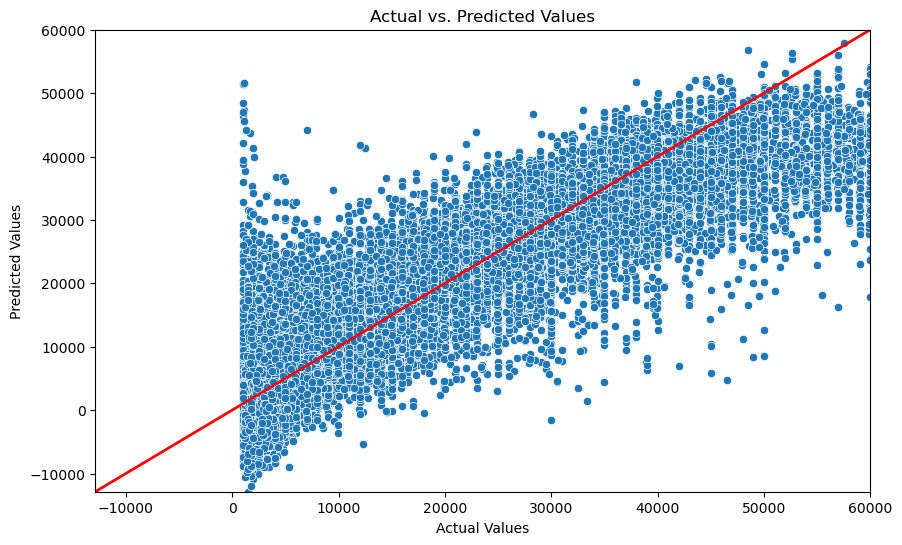

In [202]:

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual', y='Predicted', data=actual_vs_predicted_ridge_df)

# Get the minimum and maximum values for both axes
min_val = min(actual_vs_predicted_ridge_df['Actual'].min(), actual_vs_predicted_ridge_df['Predicted'].min())
max_val = max(actual_vs_predicted_ridge_df['Actual'].max(), actual_vs_predicted_ridge_df['Predicted'].max())

# Plot the line y=x
plt.plot([min_val, max_val], [min_val, max_val], color='red', linewidth=2)

# Set the limits for both axes to be the same
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

# Add labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')

plt.savefig('images/Actual_vs_Prediction.png')

# Show the plot
plt.show()

Each point on the scatter plot represents a single observation from the test set. The position of each point shows the actual value (x-coordinate) and the predicted value (y-coordinate) for that observation.

The red line represents the line of perfect prediction, where the predicted values exactly match the actual values (y = x). Points on this line indicate perfect predictions by the model.

In [203]:
# Plot actual vs. predicted values
import plotly.graph_objects as go

# Create scatter plot
fig = px.scatter(
    actual_vs_predicted_ridge_df,
    x='Actual',
    y='Predicted',
    title='Actual vs. Predicted Values',
    labels={'Actual': 'Actual Values', 'Predicted': 'Predicted Values'}
)

## Add a line for perfect predictions
#fig.add_trace(
#    go.Scatter(
#        x=[actual_vs_predicted_ridge_df['Actual'].min(), actual_vs_predicted_ridge_df['Actual'].max()],
#        y=[actual_vs_predicted_ridge_df['Actual'].min(), actual_vs_predicted_ridge_df['Actual'].max()],
#        mode='lines',
#        name='Perfect Prediction',
#        line=dict(color='red', width=2)
#    )
#)
# Enhance the plot with a 45-degree line to indicate perfect predictions
fig.add_shape(type="line", 
              line=dict(dash='dash', color = 'red'),
              name='Perfect Prediction',
              x0=actual_vs_predicted_ridge_df['Actual'].min(), y0=actual_vs_predicted_ridge_df['Actual'].min(), 
              x1=actual_vs_predicted_ridge_df['Actual'].max(), y1=actual_vs_predicted_ridge_df['Actual'].max())


# Save the plot as an HTML file
fig.write_html("images/actual_vs_predicted.html")

# To display the plot (optional)
#fig.show()
     


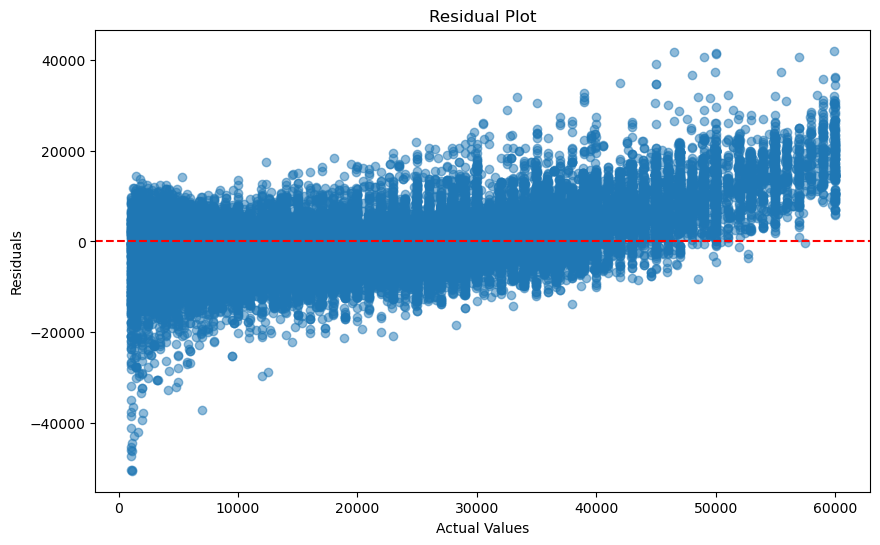

In [204]:
actual_vs_predicted_ridge_df['Residuals'] = actual_vs_predicted_ridge_df['Actual'] - actual_vs_predicted_ridge_df['Predicted']

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(actual_vs_predicted_ridge_df['Actual'], actual_vs_predicted_ridge_df['Residuals'], alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')

# Add labels and title
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

# Show the plot
plt.show()

### Actual vs predicted plots for Numerical featurs from original dataframe. 

['car_age', 'odometer', 'car_age^2', 'car_age odometer', 'odometer^2']
1 car_age
2 odometer
3 car_age^2
4 car_age odometer
5 odometer^2


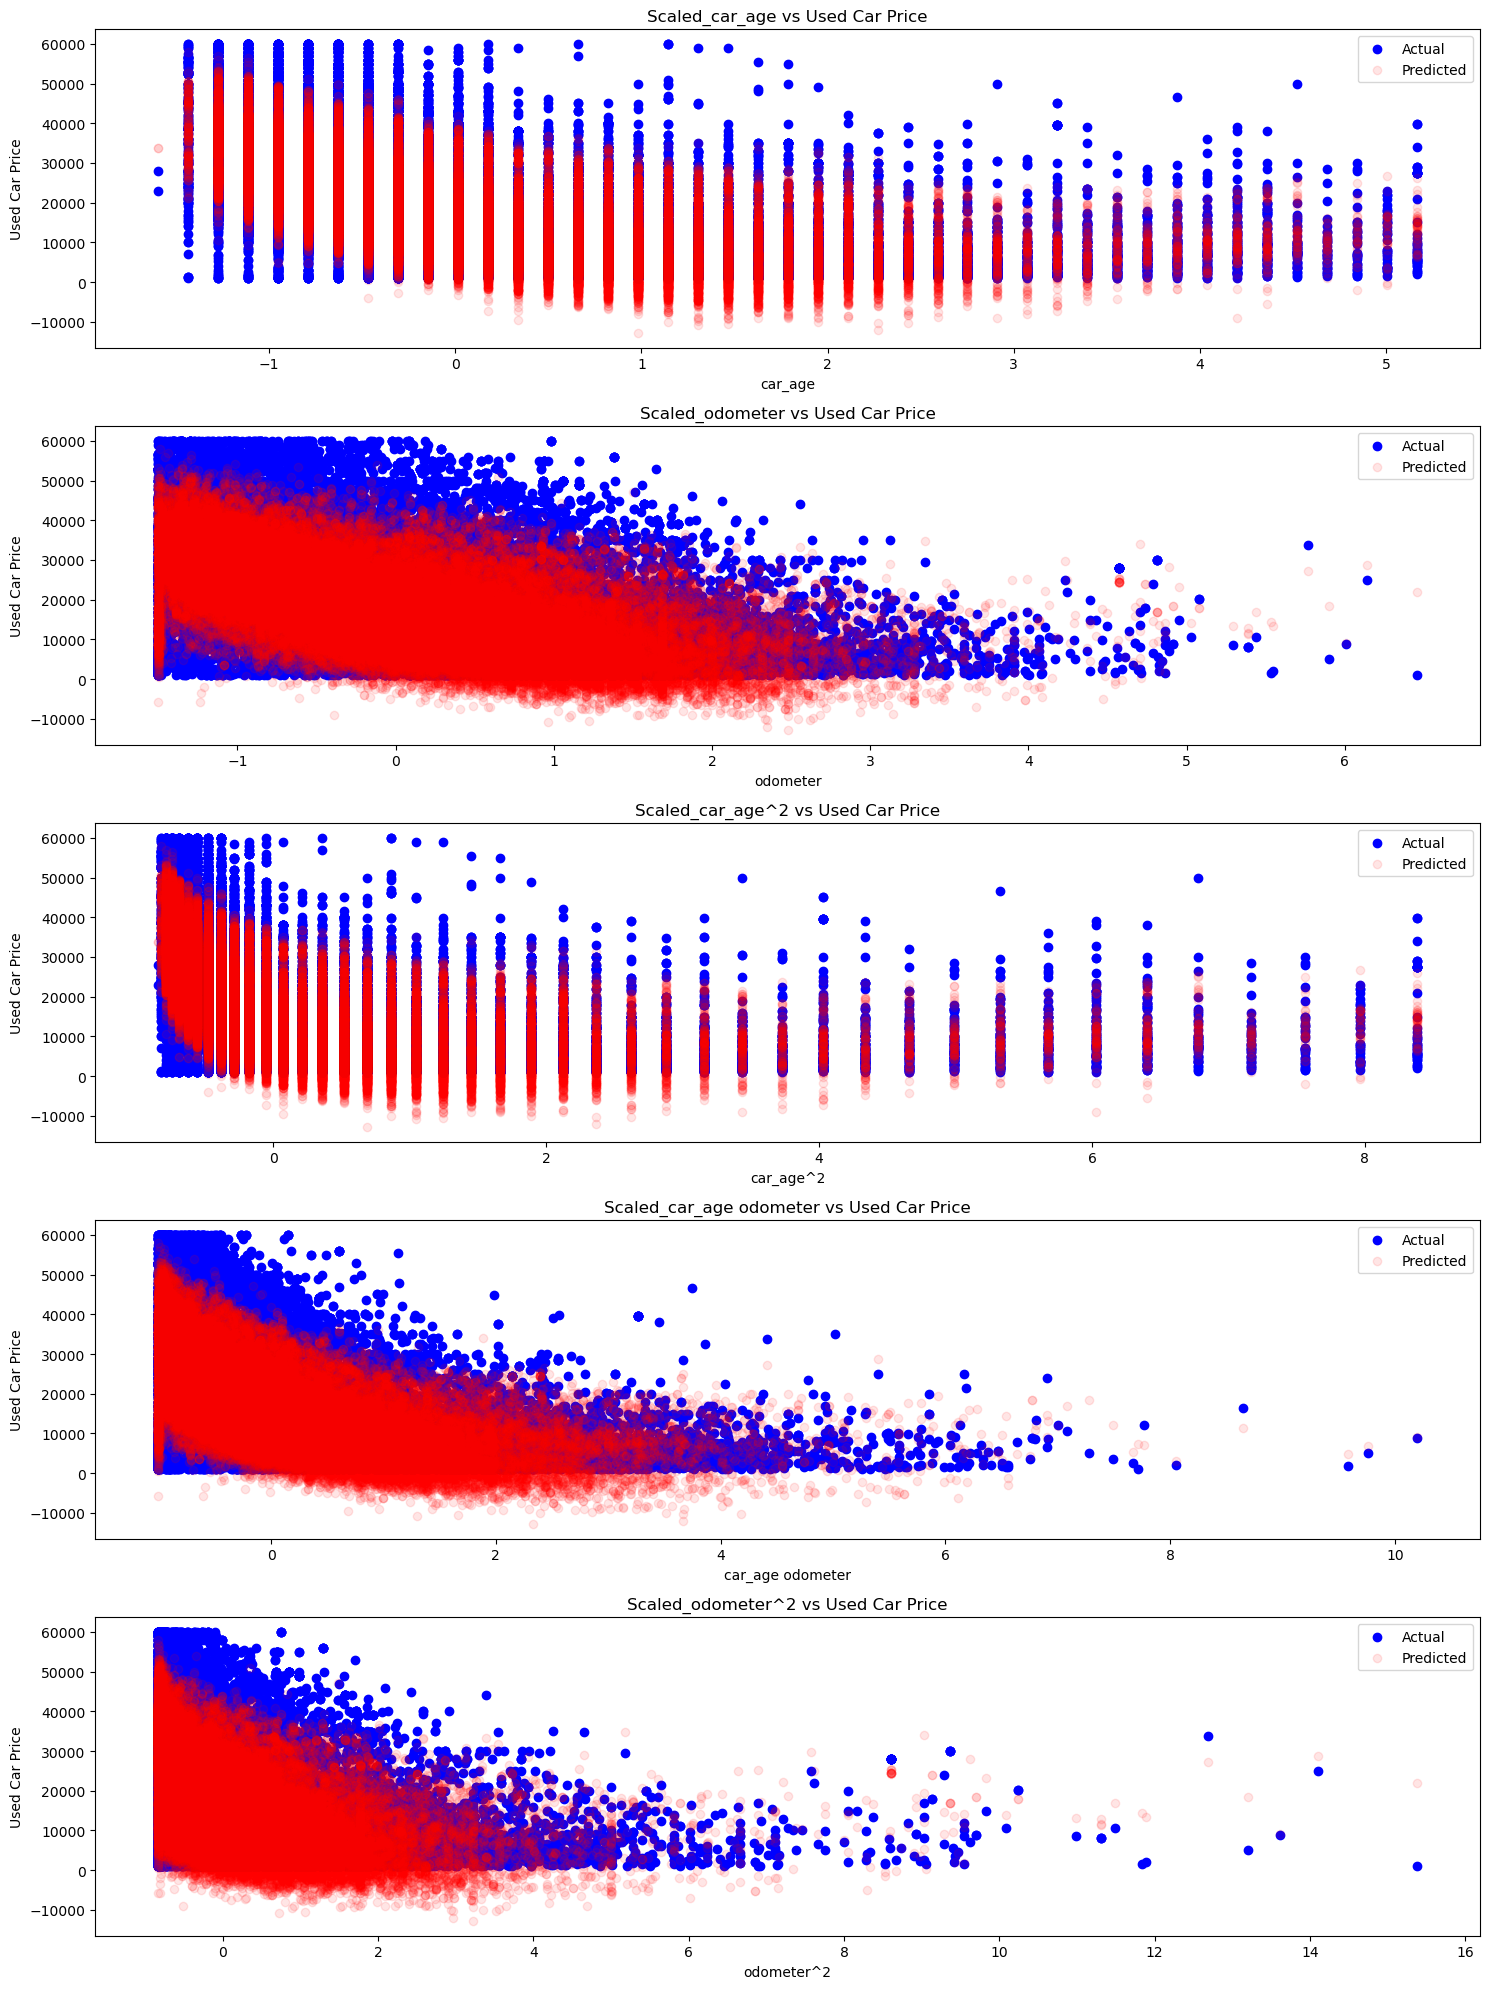

In [205]:
# Get the selected features from the model
selected_features =  [coef for coef in coefficients.index if (('simplified' not in coef) and ('condition' not in coef))]

top_10_features = selected_features[:5] 

print (top_10_features)


X_test_transformed = preprocessor_fitted.transform(X_test)
#X_test_transformed = preprocessor.transform(X_test)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=preprocessor_fitted.get_feature_names_out(), index=X_test.index)

# Create scatter plots for each selected feature against the target variable
plt.figure(figsize=(15, 20))
for i, feature in enumerate(top_10_features, 1):
    print (i, feature)
    plt.subplot(len(top_10_features), 1, i)
    plt.scatter(X_test_transformed_df[feature], y_test, color='blue', label='Actual')
    plt.scatter(X_test_transformed_df[feature], y_pred, color='red', label='Predicted', alpha=0.1)
    plt.xlabel(f'{feature}')
    plt.ylabel('Used Car Price')
    plt.title(f'Scaled_{feature} vs Used Car Price')
    plt.legend()
    
plt.tight_layout()
plt.show()

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### Evaluation Matric Choice :

I have used following two Matrics for evaluation.
1. **Root Mean Square Error (RMSE)**
   - **What is RMSE?**
     RMSE is a standard way to measure the error of a model in predicting quantitative data. Essentially, it tells you how concentrated the data is around the line of best fit.

   - **Why use RMSE?**
     - **Understandable Units:** RMSE values are in the same units as the predicted values. For example, if you are predicting the price of cars, an RMSE of 5000 means the average prediction error is about $5000.
     - **Error Sensitivity:** RMSE is especially good at identifying large errors because it squares the differences before averaging them. This means bigger errors have a disproportionately large impact on RMSE, highlighting problems in the model that might need attention.
     - **Clear Performance Indicator:** A lower RMSE value means the model has fewer and smaller errors, which is what you aim for. If you tweak your model and the RMSE goes down, it’s a sign you’re improving the model.

2. **Coefficient of Determination (R^2)**
   - **What is R^2?**
     R^2 measures how well your model’s predictions approximate the real data points. An R^2 of 1 indicates that the model perfectly predicts the data, while an R^2 of 0 means the model is no better than just predicting the mean of the data.

   - **Why use R^2?**
     - **Effectiveness of the Model:** R^2 gives you a quick insight into how much of the variance in the dependent variable your model can predict based on the independent variables.
     - **Comparison Tool:** It’s useful for comparing the strength of different predictive models. For instance, if one model has an R^2 of 0.80 and another has 0.90, you can say the second model has a better fit.
     - **Normalization:** Since R^2 is always between 0 and 1, it’s easy to interpret across different contexts and datasets, regardless of scale.

#### Matric choice summary :

- **RMSE** gives you a practical sense of how far off your model’s predictions might be in terms of dollars, which is directly applicable and easy to understand.
- **R^2** provides a percentage that tells you how much of the total variation in car prices your model captures, offering a way to gauge the model’s accuracy and usefulness.

Both metrics together provide a comprehensive view of the model’s effectiveness and areas for potential improvement, helping guide further refinements to enhance accuracy.

### ***Evaluation Results***


1. **Model Performance Metrics:**
   - **RMSE (5447.9089):** This value indicates the standard deviation of the prediction errors or residuals. In simpler terms, it represents the average distance between the predicted values by the model and the actual values. An RMSE of 5447.9089, It may be little on the higher side. May be adding gridsearch for polynomial degree and Lasso Regression or cosidering ohter regression method migh help improve it. 
   - **R^2 (0.8170):** This score explains that approximately 81.70% of the variance in the dependent variable is predictable from the independent variables. This is a strong R^2 value, suggesting that the model does a good job of capturing the patterns in the data and should provide confidence in its predictions.

2. **Insight from Coefficients:**
   - The coefficients provide detailed insights into how various features, particularly different car models and conditions, impact the value. High coefficients for specific models suggest these vehicles substantially increase the predicted value, which could guide inventory or pricing strategies.
   - Negative coefficients associated with factors like higher `car_age` and `odometer` readings reinforce typical market expectations where older cars or those with higher mileage tend to be valued lower. However, the positive coefficients for the squared terms of these variables (`car_age^2` and `odometer^3`) suggest diminishing negative impacts at higher values, which might indicate potential collector value or slower rates of depreciation for very old or well-used vehicles.

3. **Strategic Recommendations:**
   - **Inventory Management:** Highlights models with high positive coefficients as potential key inventory items. For instance, keeping a good stock of models like `simplified_model_5500` or `simplified_model_tesla` could be advantageous.
   - **Pricing Strategy:** Highlights how vehicle conditions and mileage may impact pricing. Models showing less depreciation (as indicated by the coefficients) can perhaps retain their prices better.
   - **Marketing Focus:** Vehicles with significant positive impact on value, especially luxury and high-performance vehicles, could be marketed more aggressively to maximize revenue.
   - **Geographical Considerations:** The influence of state-specific coefficients suggests that certain vehicles might fetch better prices in specific regions, possibly guiding localized marketing strategies.

4. **Further Analysis and Model Enhancement:**
   - While the current model is robust, integrating additional data sources, exploring non-linear modeling techniques, and grid search on polynomial degrees or including Sequential feature selection might help enahance the model.
   - 'model' feature is very dis-oragnized, spending some time in cleaning it up will help enhance RMSE as well. 
   
![Full Coefficient list](/data/ridge_coefficients.csv)


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

In [206]:
import joblib

# Save the trained Lasso model to a file
model_filename = 'ridge_used_car_model.pkl'
joblib.dump(best_ridge_model, model_filename)

['ridge_used_car_model.pkl']

In [207]:
loaded_model= joblib.load(model_filename)

In [208]:
def predict_used_car_prices(model, input_data):
    """
    Predict Used Car Prices using Ridge Regression Model.

    Parameter :
    - mode : Trained Ridge model
    - input_data : Dictionary containing input features for the new data.
    
    Returns :
    - predicted_values : Predicted prices of used car.
    """
    # Convert input data to dataframe
    input_data_df = pd.DataFrame(input_data)

    #Ensure input data has the same columns as training data
    input_data_df = input_data_df[X_train.columns]

    #Make Predictions
    predicted_values = model.predict(input_data_df)
    
    return predicted_values

In [209]:
#sample input data for a car
new_used_car_data = {
    'condition'         : ['good'],
    'cylinders'         : [4],
    'odometer'          : [115000],
    'title_status'      : ['clean'],
    'transmission'      : ['manual'],
    'drive'             : ['fwd'],
    'type'              : ['coupe'],
    'state'             : ['ca'],
    'car_age'           : [18],
    'simplified_model'  : ['accord']   
}

#convert sample input data to dataframe
new_car_df = pd.DataFrame(new_used_car_data)
new_car_df

,condition,cylinders,odometer,title_status,transmission,drive,type,state,car_age,simplified_model
0,good,4,115000,clean,manual,fwd,coupe,ca,18,accord


In [210]:
new_used_car_price_prediction = predict_used_car_prices(loaded_model, new_used_car_data)
used_car_predicated_value = new_used_car_price_prediction[0]

print(f'Predicted used car price for car : {used_car_predicated_value}')

Predicted used car price for car : 7856.091739883028
